<a href="https://colab.research.google.com/github/frfusch21/DTS_GGU_5/blob/Hartantya-AT/trip_duration_prediction_bog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.cluster import KMeans

from tensorflow.keras.optimizers import RMSprop

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Data**

In [6]:
uio = pd.read_csv('/content/drive/MyDrive/Belajar/bog_clean.csv', header=0, sep=',', encoding="Latin1")
uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,BogotÃ¡,2016-09-18 01:54:11,2016-09-18 02:17:49,-74.170353,4.622699,-74.119259,4.572322,N,1419,11935,293
1,2,BogotÃ¡,2016-09-18 03:31:05,2016-09-18 03:44:06,-74.123542,4.604075,-74.116125,4.572578,N,782,7101,139
2,3,BogotÃ¡,2016-08-07 03:35:36,2016-09-18 04:30:31,-74.178643,4.646176,-74.178711,4.646367,N,3632095,2655,2534
3,4,BogotÃ¡,2016-09-18 04:31:13,2016-09-18 04:32:19,-74.163398,4.641949,-74.165813,4.640649,N,66,318,52
4,5,BogotÃ¡,2016-09-13 12:07:04,2016-09-18 05:00:44,-74.137539,4.596347,-74.125364,4.576745,N,449620,3228,211


In [7]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,3063.000000,3063.000000,3063.000000,3063.000000,3063.000000,3.063000e+03,3.063000e+03,3.063000e+03
mean,1532.000000,-74.098884,4.670920,-74.100136,4.669038,9.295603e+04,-1.392301e+06,9.652921e+05
std,884.356263,0.138975,0.091885,0.139508,0.092942,5.899404e+05,5.486590e+07,3.757377e+07
min,1.000000,-76.534419,3.391712,-76.542536,3.391941,2.000000e+00,-2.147484e+09,0.000000e+00
25%,766.500000,-74.123948,4.629166,-74.122538,4.625974,5.385000e+02,1.672000e+03,9.100000e+01
50%,1532.000000,-74.085985,4.683676,-74.089411,4.677560,1.442000e+03,5.375000e+03,3.000000e+02
75%,2297.500000,-74.055464,4.717402,-74.058683,4.719314,3.813000e+03,1.085600e+04,8.445000e+02
max,3063.000000,-73.829723,5.029401,-73.615700,5.029189,1.227617e+07,3.478510e+05,1.471920e+09


In [8]:
uio.shape

(3063, 12)

# **Analisis Secara Umum**

In [9]:
print(uio['vendor_id'].unique())
print(uio['store_and_fwd_flag'].unique())

['BogotÃ¡' 'BogotÃ¡ UberX' 'Bogota UberBlack' 'BogotÃ¡ UberVan'
 'BogotÃ¡ UberAngel']
['N']


In [10]:
print(uio.groupby(['vendor_id'])['id'].count().reset_index())

           vendor_id    id
0   Bogota UberBlack   244
1            BogotÃ¡  2537
2  BogotÃ¡ UberAngel    11
3    BogotÃ¡ UberVan    54
4      BogotÃ¡ UberX   217


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


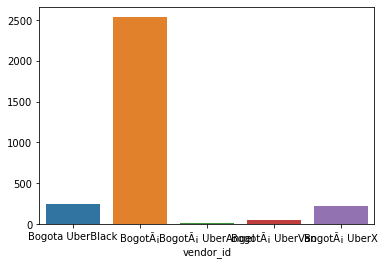

In [11]:
x = uio.groupby(['vendor_id'])['id'].count()
sns.barplot(x.index, x.values)

In [12]:
uio.isnull().values.any()

False

In [13]:
uio =  uio.loc[uio['vendor_id']=='BogotÃ¡']

In [14]:
correlation_matrix = uio.corr()
correlation_matrix

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
id,1.000000,0.001876,0.049489,-0.000680,0.056549,0.024598,-0.021393,0.022904
pickup_longitude,0.001876,1.000000,0.562691,0.641561,0.409979,-0.072542,0.016071,-0.011065
pickup_latitude,0.049489,0.562691,1.000000,0.421037,0.707961,0.003453,0.026968,-0.008690
dropoff_longitude,-0.000680,0.641561,0.421037,1.000000,0.466282,-0.056963,0.007385,-0.010016
dropoff_latitude,0.056549,0.409979,0.707961,0.466282,1.000000,-0.009344,0.010231,-0.007082
trip_duration,0.024598,-0.072542,0.003453,-0.056963,-0.009344,1.000000,0.004492,-0.004085
dist_meters,-0.021393,0.016071,0.026968,0.007385,0.010231,0.004492,1.000000,0.000788
wait_sec,0.022904,-0.011065,-0.008690,-0.010016,-0.007082,-0.004085,0.000788,1.000000


# **Analisis Data Trip Duration**

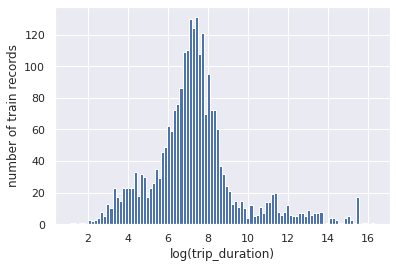

In [15]:
sns.set()
uio['log_trip_duration'] = np.log(uio['trip_duration'].values + 1)
plt.hist(uio['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


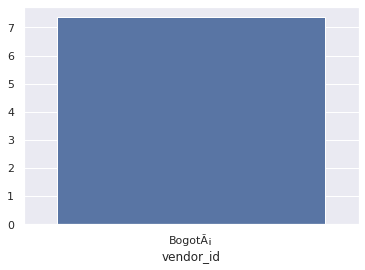

In [16]:
x = uio.groupby(['vendor_id'])['log_trip_duration'].mean()
sns.barplot(x.index, x.values)

In [17]:
print((uio['trip_duration'].min())/3600)
print((uio['trip_duration'].max())/3600)

0.0005555555555555556
3410.0461111111113


In [18]:
uio['trip_duration_in_minutes'] =  uio['trip_duration']/60

In [19]:
uio = uio[(uio['trip_duration_in_minutes'] >= 0.05)]
uio.shape

(2536, 14)

In [20]:
print((uio['trip_duration_in_minutes'].min()))
print((uio['trip_duration_in_minutes'].max()))

0.05
204602.76666666666


In [21]:
z_scores = stats.zscore(uio[['trip_duration_in_minutes']])
z_scores

# Convert to absolute values
abs_z_scores = np.abs(z_scores)

# Select data points with a z-scores above or below 3
filtered_entries = (abs_z_scores < 3).all(axis=1)
# Filter the dataset
uio = uio[filtered_entries]
uio.shape

(2501, 14)

In [22]:
print((uio['trip_duration_in_minutes'].min()))
print((uio['trip_duration_in_minutes'].max()))

0.05
29993.65


In [23]:
# calculate Q1 and Q3
Q1 = uio[['trip_duration_in_minutes']].quantile(0.25)
Q3 = uio[['trip_duration_in_minutes']].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# filter the dataset with the IQR
IQR_outliers =  uio[['trip_duration_in_minutes']][(( uio[['trip_duration_in_minutes']] < (Q1 - 1.5 * IQR)) |( uio[['trip_duration_in_minutes']] > (Q3 + 1.5 * IQR))).any(axis=1)]
min_outlier = IQR_outliers.min()
print(min_outlier)

trip_duration_in_minutes    121.1
dtype: float64


In [24]:
uio = uio[(uio['trip_duration_in_minutes'] < 121.1)]
uio.shape

(2170, 14)

# **Analisis Data Datetime**

In [25]:
uio['pickup_datetime'] = pd.to_datetime(uio['pickup_datetime'], format='%Y/%m/%d %H:%M:%S')
uio['dropoff_datetime'] = pd.to_datetime(uio['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [26]:
print('Pickup -> Date : max = ', uio['pickup_datetime'].dt.date.max(), ' & min = ',uio['pickup_datetime'].dt.date.min(), ' || Time : Max = ', uio['pickup_datetime'].dt.time.max(), ' & min = ', uio['pickup_datetime'].dt.time.min())

print('Dropoff -> Date : max = ', uio['dropoff_datetime'].dt.date.max(), ' & min = ',uio['dropoff_datetime'].dt.date.min(), ' || Time : Max = ', uio['dropoff_datetime'].dt.time.max(), ' & min = ', uio['dropoff_datetime'].dt.time.min())

Pickup -> Date : max =  2017-07-20  & min =  2016-06-23  || Time : Max =  12:59:57  & min =  01:00:01
Dropoff -> Date : max =  2017-07-20  & min =  2016-06-23  || Time : Max =  12:59:22  & min =  01:00:50


In [27]:
uio['diff_datetime_minutes'] = (uio['dropoff_datetime']-uio['pickup_datetime']).dt.total_seconds()/60

In [28]:
uio[(uio['trip_duration_in_minutes'] != uio['diff_datetime_minutes'])]

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec,log_trip_duration,trip_duration_in_minutes,diff_datetime_minutes
0,1,BogotÃ¡,2016-09-18 01:54:11,2016-09-18 02:17:49,-74.170353,4.622699,-74.119259,4.572322,N,1419,11935,293,7.258412,23.650000,23.633333
1,2,BogotÃ¡,2016-09-18 03:31:05,2016-09-18 03:44:06,-74.123542,4.604075,-74.116125,4.572578,N,782,7101,139,6.663133,13.033333,13.016667
5,6,BogotÃ¡,2016-09-18 05:39:06,2016-09-18 06:37:07,-74.026595,4.761352,-74.086588,4.578945,N,3482,27760,796,8.155649,58.033333,58.016667
6,7,BogotÃ¡,2016-09-18 07:33:15,2016-09-18 08:07:08,-74.155331,4.599743,-74.038229,4.764599,N,2034,27136,215,7.618251,33.900000,33.883333
8,9,BogotÃ¡,2016-09-18 10:11:54,2016-09-18 10:17:01,-74.049272,4.718333,-74.030313,4.710932,N,308,2358,93,5.733341,5.133333,5.116667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053,3054,BogotÃ¡,2016-10-27 04:13:14,2016-10-27 04:15:33,-74.161670,4.591986,-74.157820,4.581066,N,140,1313,18,4.948760,2.333333,2.316667
3054,3055,BogotÃ¡,2016-10-27 04:16:10,2016-10-27 04:42:08,-74.156281,4.578133,-74.157015,4.565806,N,1559,3940,1039,7.352441,25.983333,25.966667
3055,3056,BogotÃ¡,2016-10-27 06:37:55,2016-10-27 07:50:48,-74.154898,4.637313,-74.048568,4.684500,N,4374,14743,1193,8.383662,72.900000,72.883333
3056,3057,BogotÃ¡,2016-10-27 09:00:36,2016-10-27 09:52:21,-74.072112,4.631299,-74.042742,4.701864,N,3106,11368,780,8.041413,51.766667,51.750000


In [29]:
uio = uio[(uio['diff_datetime_minutes'] >= 0)]
uio.shape

(2105, 15)

# **Data Trip Duration VS Datetime**

In [30]:
uio['pickup_month'] = uio['pickup_datetime'].dt.month
uio['pickup_year'] = uio['pickup_datetime'].dt.year
uio['pickup_day'] = uio['pickup_datetime'].dt.day
uio['pickup_hour'] = uio['pickup_datetime'].dt.hour
uio['pickup_minute'] = uio['pickup_datetime'].dt.minute
uio['pickup_day_of_week'] = uio['pickup_datetime'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

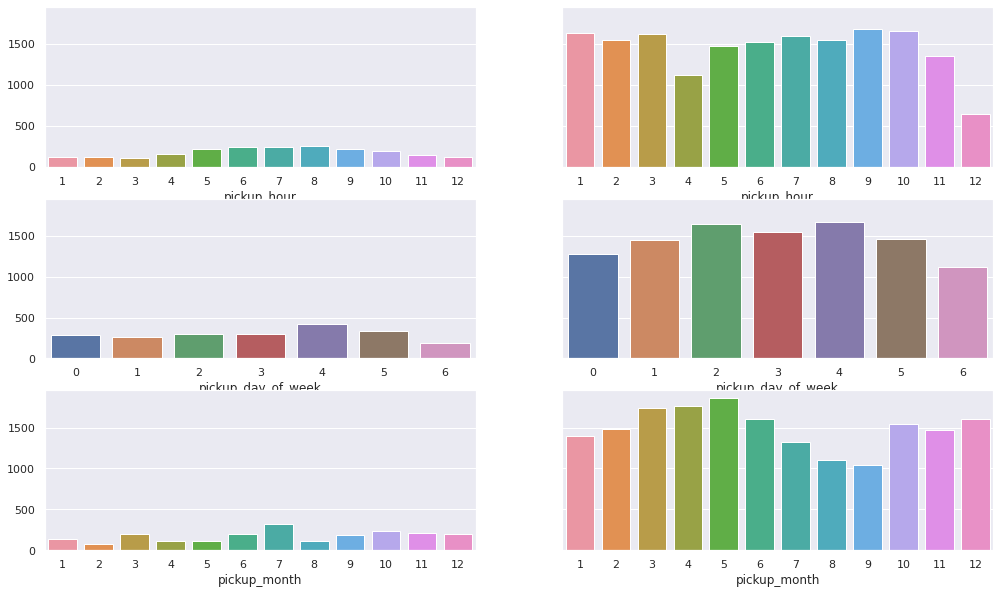

In [31]:
f, axes = plt.subplots(3,2,figsize=(17,10), sharey=True)

dat = uio.groupby(['pickup_hour'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[0,0])
#fig1.set_ylim = 3000

dat = uio.groupby(['pickup_hour'])['trip_duration'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[0,1])
#fig2.set_ylim = 3000

dat = uio.groupby(['pickup_day_of_week'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[1,0])
#fig1.set_ylim = 3000

dat = uio.groupby(['pickup_day_of_week'])['trip_duration'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[1,1])

dat = uio.groupby(['pickup_month'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[2,0])
#fig1.set_ylim = 3000

dat = uio.groupby(['pickup_month'])['trip_duration'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[2,1])

# **Analisis Data Distance Meters**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


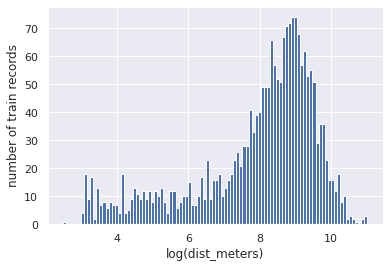

In [32]:
sns.set()
uio['log_dist_meters'] = np.log(uio['dist_meters'].values + 1)
plt.hist(uio['log_dist_meters'].values, bins=100)
plt.xlabel('log(dist_meters)')
plt.ylabel('number of train records')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


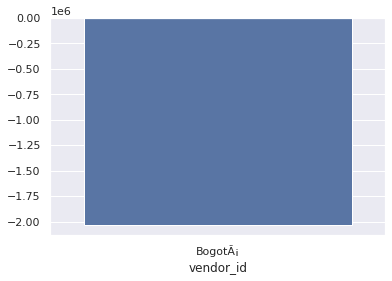

In [33]:
x = uio.groupby(['vendor_id'])['dist_meters'].mean()
sns.barplot(x.index, x.values)

In [34]:
print((uio['dist_meters'].min())/1000)
print((uio['dist_meters'].max())/1000)

-2147483.648
60.853


In [35]:
uio['dist_kilometers'] =  uio['dist_meters']/1000

In [36]:
z_scores = stats.zscore(uio[['dist_kilometers']])
z_scores

# Convert to absolute values
abs_z_scores = np.abs(z_scores)

# Select data points with a z-scores above or below 3
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Filter the dataset
uio = uio[filtered_entries]
uio.shape

(2103, 23)

In [37]:
print((uio['dist_kilometers'].min()))
print((uio['dist_kilometers'].max()))

0.011
60.853


In [38]:
# calculate Q1 and Q3
Q1 = uio[['dist_kilometers']].quantile(0.25)
Q3 = uio[['dist_kilometers']].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# filter the dataset with the IQR
IQR_outliers =  uio[['dist_kilometers']][(( uio[['dist_kilometers']] < (Q1 - 1.5 * IQR)) |( uio[['dist_kilometers']] > (Q3 + 1.5 * IQR))).any(axis=1)]
min_outlier = IQR_outliers.min()
print(min_outlier)

dist_kilometers    20.231
dtype: float64


In [39]:
uio = uio[(uio['dist_kilometers'] < 20.231)]
uio.shape

(2011, 23)

# **Clustering**

In [40]:
num_clusters = 2

Pickup

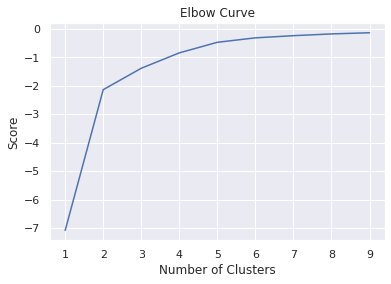

In [41]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['pickup_latitude']]
X_axis = uio[['pickup_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [42]:
kmeans = KMeans(n_clusters = num_clusters, init ='k-means++', max_iter=100, n_init=1, verbose=0, random_state=3425)
kmeans.fit(uio[['pickup_latitude', 'pickup_longitude']]) # Compute k-means clustering.
uio['cluster_pickup'] = kmeans.fit_predict(uio[['pickup_latitude', 'pickup_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['pickup_latitude', 'pickup_longitude']]) # Labels of each point
uio.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,diff_datetime_minutes,pickup_month,pickup_year,pickup_day,pickup_hour,pickup_minute,pickup_day_of_week,log_dist_meters,dist_kilometers,cluster_pickup
0,1,BogotÃ¡,2016-09-18 01:54:11,2016-09-18 02:17:49,-74.170353,4.622699,-74.119259,4.572322,N,1419,...,23.633333,9,2016,18,1,54,6,9.387314,11.935,0
1,2,BogotÃ¡,2016-09-18 03:31:05,2016-09-18 03:44:06,-74.123542,4.604075,-74.116125,4.572578,N,782,...,13.016667,9,2016,18,3,31,6,8.868132,7.101,0
3,4,BogotÃ¡,2016-09-18 04:31:13,2016-09-18 04:32:19,-74.163398,4.641949,-74.165813,4.640649,N,66,...,1.100000,9,2016,18,4,31,6,5.765191,0.318,0
7,8,BogotÃ¡,2016-09-18 10:08:31,2016-09-18 10:11:42,-74.049168,4.736697,-74.050641,4.718745,N,191,...,3.183333,9,2016,18,10,8,6,7.807510,2.458,1
8,9,BogotÃ¡,2016-09-18 10:11:54,2016-09-18 10:17:01,-74.049272,4.718333,-74.030313,4.710932,N,308,...,5.116667,9,2016,18,10,11,6,7.765993,2.358,1
9,10,BogotÃ¡,2016-09-19 06:38:17,2016-09-19 06:56:23,-74.129042,4.656129,-74.164118,4.623704,N,1086,...,18.100000,9,2016,19,6,38,0,8.678802,5.876,0
11,12,BogotÃ¡,2016-09-19 12:16:52,2016-09-19 12:44:15,-74.107296,4.654408,-74.102383,4.615875,N,1643,...,27.383333,9,2016,19,12,16,0,8.878776,7.177,0
13,14,BogotÃ¡,2016-09-19 01:39:38,2016-09-19 01:54:46,-74.050705,4.752136,-74.050896,4.752045,N,909,...,15.133333,9,2016,19,1,39,0,8.934719,7.590,1
14,15,BogotÃ¡,2016-09-19 02:05:05,2016-09-19 02:05:48,-74.076370,4.606665,-74.077545,4.607023,N,43,...,0.716667,9,2016,19,2,5,0,5.198497,0.180,0
15,16,BogotÃ¡,2016-09-19 02:06:00,2016-09-19 02:16:14,-74.077873,4.607366,-74.091487,4.604315,N,615,...,10.233333,9,2016,19,2,6,0,7.701652,2.211,0


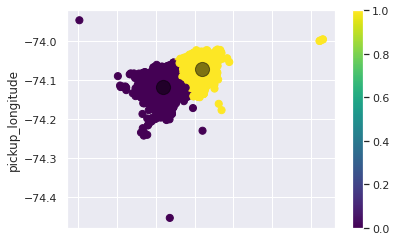

In [43]:
uio.plot.scatter(x = 'pickup_latitude', y = 'pickup_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


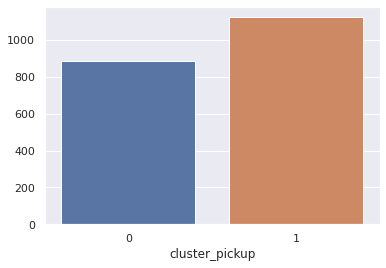

In [44]:
x = uio.groupby(['cluster_pickup'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


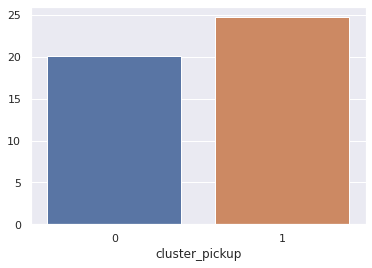

In [45]:
x = uio.groupby(['cluster_pickup'])['trip_duration_in_minutes'].mean()
sns.barplot(x.index, x.values)
plt.show()

Dropoff

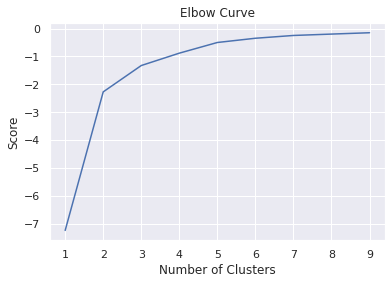

In [46]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['dropoff_latitude']]
X_axis = uio[['dropoff_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [47]:
kmeans = KMeans(n_clusters = num_clusters, init ='k-means++', max_iter=100, n_init=1, verbose=0, random_state=3425)
kmeans.fit(uio[['dropoff_latitude', 'dropoff_longitude']]) # Compute k-means clustering.
uio['cluster_dropoff'] = kmeans.fit_predict(uio[['dropoff_latitude', 'dropoff_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['dropoff_latitude', 'dropoff_longitude']]) # Labels of each point
uio.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,pickup_month,pickup_year,pickup_day,pickup_hour,pickup_minute,pickup_day_of_week,log_dist_meters,dist_kilometers,cluster_pickup,cluster_dropoff
0,1,BogotÃ¡,2016-09-18 01:54:11,2016-09-18 02:17:49,-74.170353,4.622699,-74.119259,4.572322,N,1419,...,9,2016,18,1,54,6,9.387314,11.935,0,0
1,2,BogotÃ¡,2016-09-18 03:31:05,2016-09-18 03:44:06,-74.123542,4.604075,-74.116125,4.572578,N,782,...,9,2016,18,3,31,6,8.868132,7.101,0,0
3,4,BogotÃ¡,2016-09-18 04:31:13,2016-09-18 04:32:19,-74.163398,4.641949,-74.165813,4.640649,N,66,...,9,2016,18,4,31,6,5.765191,0.318,0,0
7,8,BogotÃ¡,2016-09-18 10:08:31,2016-09-18 10:11:42,-74.049168,4.736697,-74.050641,4.718745,N,191,...,9,2016,18,10,8,6,7.807510,2.458,1,1
8,9,BogotÃ¡,2016-09-18 10:11:54,2016-09-18 10:17:01,-74.049272,4.718333,-74.030313,4.710932,N,308,...,9,2016,18,10,11,6,7.765993,2.358,1,1
9,10,BogotÃ¡,2016-09-19 06:38:17,2016-09-19 06:56:23,-74.129042,4.656129,-74.164118,4.623704,N,1086,...,9,2016,19,6,38,0,8.678802,5.876,0,0
11,12,BogotÃ¡,2016-09-19 12:16:52,2016-09-19 12:44:15,-74.107296,4.654408,-74.102383,4.615875,N,1643,...,9,2016,19,12,16,0,8.878776,7.177,0,0
13,14,BogotÃ¡,2016-09-19 01:39:38,2016-09-19 01:54:46,-74.050705,4.752136,-74.050896,4.752045,N,909,...,9,2016,19,1,39,0,8.934719,7.590,1,1
14,15,BogotÃ¡,2016-09-19 02:05:05,2016-09-19 02:05:48,-74.076370,4.606665,-74.077545,4.607023,N,43,...,9,2016,19,2,5,0,5.198497,0.180,0,0
15,16,BogotÃ¡,2016-09-19 02:06:00,2016-09-19 02:16:14,-74.077873,4.607366,-74.091487,4.604315,N,615,...,9,2016,19,2,6,0,7.701652,2.211,0,0


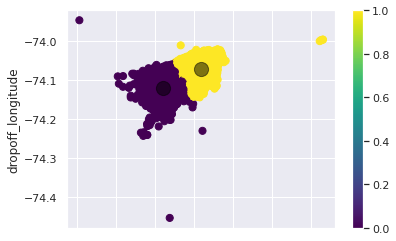

In [48]:
uio.plot.scatter(x = 'dropoff_latitude', y = 'dropoff_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


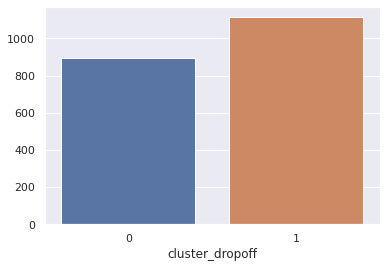

In [49]:
x = uio.groupby(['cluster_dropoff'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


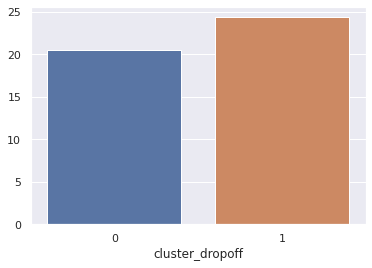

In [50]:
x = uio.groupby(['cluster_dropoff'])['trip_duration_in_minutes'].mean()
sns.barplot(x.index, x.values)
plt.show()

# **Cek Korelasi**

In [51]:
uio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 0 to 3061
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        2011 non-null   int64         
 1   vendor_id                 2011 non-null   object        
 2   pickup_datetime           2011 non-null   datetime64[ns]
 3   dropoff_datetime          2011 non-null   datetime64[ns]
 4   pickup_longitude          2011 non-null   float64       
 5   pickup_latitude           2011 non-null   float64       
 6   dropoff_longitude         2011 non-null   float64       
 7   dropoff_latitude          2011 non-null   float64       
 8   store_and_fwd_flag        2011 non-null   object        
 9   trip_duration             2011 non-null   int64         
 10  dist_meters               2011 non-null   int64         
 11  wait_sec                  2011 non-null   int64         
 12  log_trip_duration   

In [52]:
correlation_matrix = uio.corr()
print(correlation_matrix['trip_duration'])

id                          0.008831
pickup_longitude            0.082403
pickup_latitude             0.127188
dropoff_longitude           0.074405
dropoff_latitude            0.106540
trip_duration               1.000000
dist_meters                 0.634449
wait_sec                   -0.030354
log_trip_duration           0.787982
trip_duration_in_minutes    1.000000
diff_datetime_minutes       0.313254
pickup_month                0.004506
pickup_year                 0.067830
pickup_day                  0.039965
pickup_hour                -0.071266
pickup_minute               0.051755
pickup_day_of_week         -0.012163
log_dist_meters             0.540118
dist_kilometers             0.634449
cluster_pickup              0.102883
cluster_dropoff             0.083562
Name: trip_duration, dtype: float64


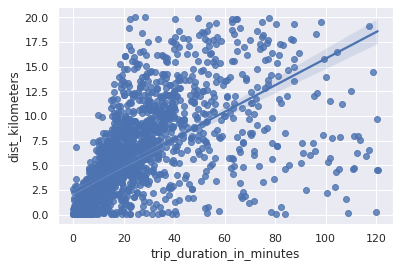

In [53]:
sns.regplot(x=uio["trip_duration_in_minutes"], y=uio["dist_kilometers"])

In [54]:
df_uio = uio[['trip_duration','dist_meters']]
x = df_uio.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

df.columns = [list(df_uio.columns)]
print(df)

     trip_duration dist_meters
0         0.195851    0.594328
1         0.107746    0.353387
2         0.008714    0.015302
3         0.026003    0.121966
4         0.042185    0.116982
...            ...         ...
2006      0.018949    0.064896
2007      0.215214    0.195833
2008      0.604564    0.734287
2009      0.429184    0.566067
2010      0.724343    0.787121

[2011 rows x 2 columns]


In [55]:
correlation_matrix = df.corr()
print(correlation_matrix)

              trip_duration dist_meters
trip_duration      1.000000    0.634449
dist_meters        0.634449    1.000000


# **Split Data**

In [151]:
#uio_fix = uio[['trip_duration_in_minutes', 'dist_kilometers','pickup_hour']]
uio_fix = uio[['trip_duration_in_minutes', 'dist_kilometers','pickup_hour','pickup_month','pickup_year','pickup_latitude','pickup_longitude','cluster_pickup','cluster_dropoff']]
#uio_fix = uio[['trip_duration_in_minutes', 'dist_kilometers','pickup_hour','pickup_month','pickup_year','pickup_latitude','pickup_longitude']]

In [152]:
uio_fix

,trip_duration_in_minutes,dist_kilometers,pickup_hour,pickup_month,pickup_year,pickup_latitude,pickup_longitude,cluster_pickup,cluster_dropoff
0,23.650000,11.935,1,9,2016,4.622699,-74.170353,0,0
1,13.033333,7.101,3,9,2016,4.604075,-74.123542,0,0
3,1.100000,0.318,4,9,2016,4.641949,-74.163398,0,0
7,3.183333,2.458,10,9,2016,4.736697,-74.049168,1,1
8,5.133333,2.358,10,9,2016,4.718333,-74.049272,1,1
...,...,...,...,...,...,...,...,...,...
3053,2.333333,1.313,4,10,2016,4.591986,-74.161670,0,0
3054,25.983333,3.940,4,10,2016,4.578133,-74.156281,0,0
3055,72.900000,14.743,6,10,2016,4.637313,-74.154898,0,1
3056,51.766667,11.368,9,10,2016,4.631299,-74.072112,0,1


In [153]:
train_dataset = uio_fix.sample(frac=0.8, random_state=0)
test_dataset = uio_fix.drop(train_dataset.index)

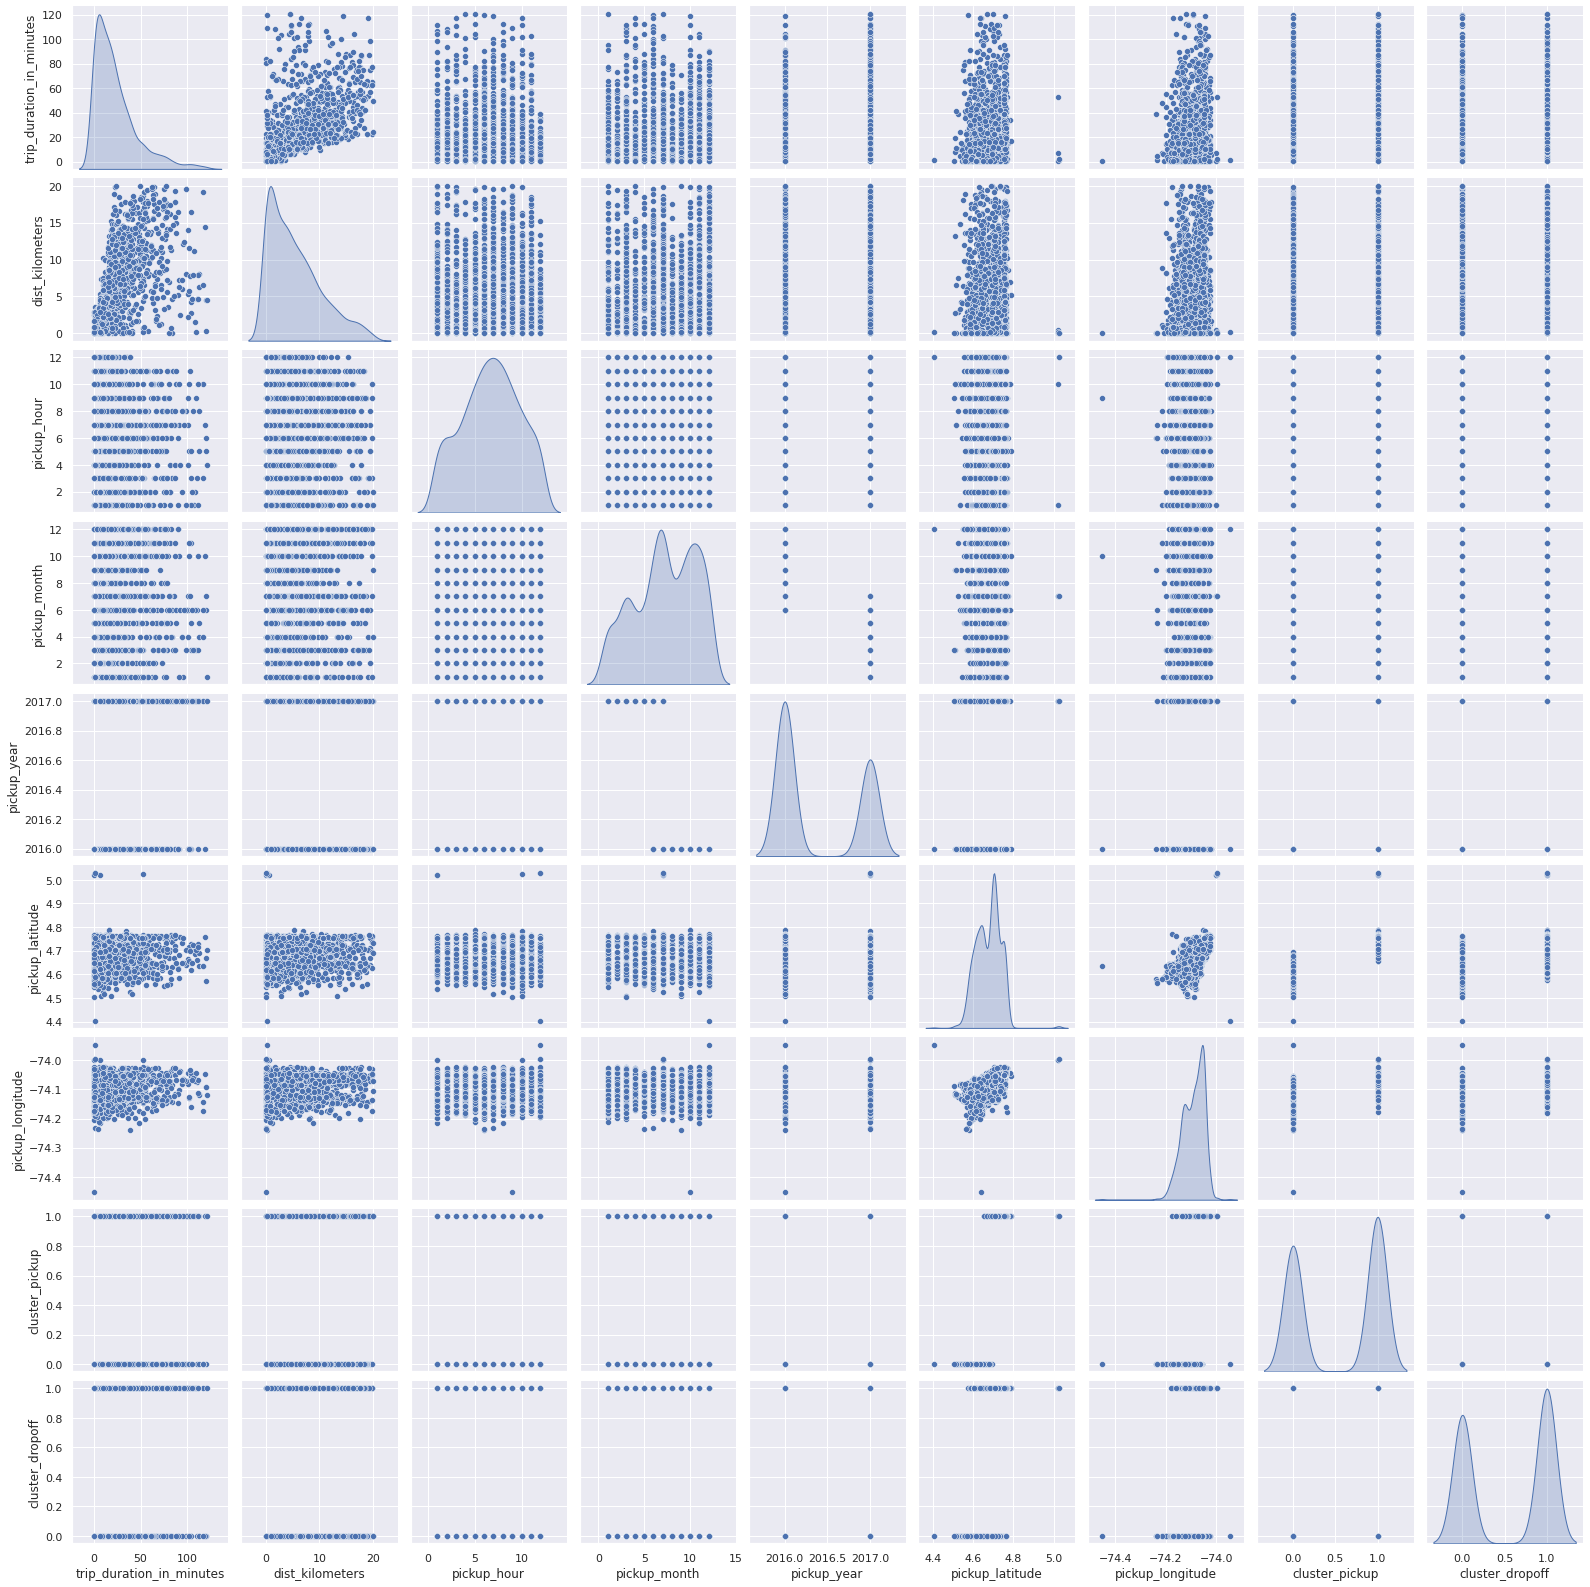

In [154]:
sns.pairplot(train_dataset, diag_kind='kde')

In [155]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
trip_duration_in_minutes,1609.0,23.015786,22.909538,0.050000,6.116667,16.900000,31.966667,120.550000
dist_kilometers,1609.0,5.439548,4.873559,0.011000,1.280000,4.248000,8.316000,20.016000
pickup_hour,1609.0,6.674332,3.036608,1.000000,4.000000,7.000000,9.000000,12.000000
pickup_month,1609.0,7.252952,3.264848,1.000000,5.000000,7.000000,10.000000,12.000000
pickup_year,1609.0,2016.384711,0.486678,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
pickup_latitude,1609.0,4.674357,0.060338,4.404473,4.628135,4.687737,4.714473,5.029401
pickup_longitude,1609.0,-74.092529,0.041880,-74.452713,-74.123773,-74.086499,-74.056637,-73.947104
cluster_pickup,1609.0,0.551274,0.497519,0.000000,0.000000,1.000000,1.000000,1.000000
cluster_dropoff,1609.0,0.546302,0.498006,0.000000,0.000000,1.000000,1.000000,1.000000


In [156]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('trip_duration_in_minutes')
test_labels = test_features.pop('trip_duration_in_minutes')

In [157]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
trip_duration_in_minutes,23.015786,22.909538
dist_kilometers,5.439548,4.873559
pickup_hour,6.674332,3.036608
pickup_month,7.252952,3.264848
pickup_year,2016.384711,0.486678
pickup_latitude,4.674357,0.060338
pickup_longitude,-74.092529,0.041880
cluster_pickup,0.551274,0.497519
cluster_dropoff,0.546302,0.498006


In [158]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 5.4395480e+00  6.6743317e+00  7.2529526e+00  2.0163851e+03
   4.6743569e+00 -7.4092529e+01  5.5127412e-01  5.4630196e-01]]


In [159]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   0.04    4.      3.   2017.      4.63  -74.18    0.      0.  ]]

Normalized: [[-1.11 -0.88 -1.3   1.26 -0.69 -2.11 -1.11 -1.1 ]]


# **Callback**

In [160]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=8.1 and  logs.get('loss')<=9.1):
      print("\nScore MAE reached 8.01 so cancelling training!")
      self.model.stop_training = True
callback = myCallback()

# **Regression - Adam**

In [181]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [182]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 64)                576       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
__________________________________________________

In [183]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size = 100,
    validation_split=0.2,
    #verbose=0, 
    epochs=500,
    callbacks = [callback])

Epoch 1/500
13/13 [==============================] - 1s 18ms/step - loss: 22.8321 - val_loss: 20.3216
Epoch 2/500
13/13 [==============================] - 0s 9ms/step - loss: 21.9706 - val_loss: 19.4840
Epoch 3/500
13/13 [==============================] - 0s 7ms/step - loss: 20.9746 - val_loss: 18.4699
Epoch 4/500
13/13 [==============================] - 0s 6ms/step - loss: 19.7021 - val_loss: 17.1161
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 18.1434 - val_loss: 15.4594
Epoch 6/500
13/13 [==============================] - 0s 6ms/step - loss: 16.5254 - val_loss: 14.0217
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 15.1854 - val_loss: 13.0010
Epoch 8/500
13/13 [==============================] - 0s 7ms/step - loss: 14.2528 - val_loss: 12.3454
Epoch 9/500
13/13 [==============================] - 0s 7ms/step - loss: 13.6485 - val_loss: 11.6950
Epoch 10/500
13/13 [==============================] - 0s 7ms/step - loss: 13.0385 - val_lo

In [184]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 25])
  plt.xlabel('Epoch')
  plt.ylabel('Error [trip_duration_in_minutes]')
  plt.legend()
  plt.grid(True)

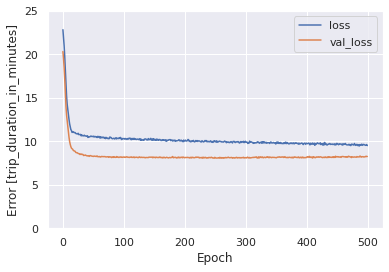

In [185]:
plot_loss(history)

In [186]:
test_results = {}

In [187]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [188]:
pd.DataFrame(test_results, index=['Mean absolute error [trip_duration]']).T

,Mean absolute error [trip_duration]
dnn_model,8.996419


# **Make Prediction - Adam**

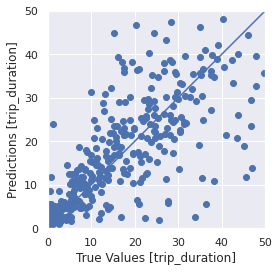

In [189]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [trip_duration]')
plt.ylabel('Predictions [trip_duration]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

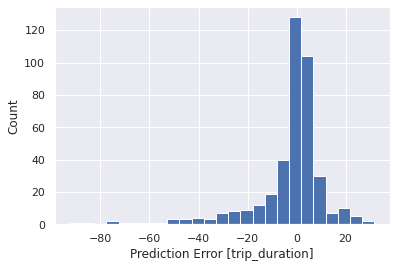

In [190]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [trip_duration]')
_ = plt.ylabel('Count')

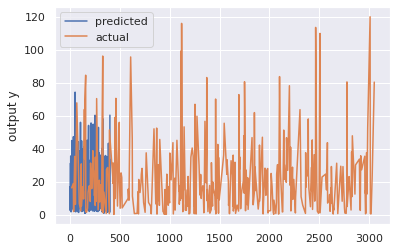

In [191]:
plt.figure()
plt.plot(test_predictions, label='predicted')
plt.plot(test_labels, label='actual')
plt.ylabel('output y')
plt.legend()
plt.show()

In [192]:
print(test_predictions[0:5])

[17.045607  13.816239   2.7043781  4.651676   6.5648108]


In [193]:
print(test_labels[0:5])

18    16.333333
34    18.950000
37     1.966667
38     4.866667
44    20.633333
Name: trip_duration_in_minutes, dtype: float64


In [194]:
print(test_features[0:5])

    dist_kilometers  pickup_hour  pickup_month  pickup_year  pickup_latitude  \
18            4.766            7             9         2016         4.595093   
34            3.681           11             9         2016         4.578534   
37            0.558           12             9         2016         4.597882   
38            0.663            1             9         2016         4.716862   
44            1.564            4             9         2016         4.704668   

    pickup_longitude  cluster_pickup  cluster_dropoff  
18        -74.073965               0                0  
34        -74.128194               0                0  
37        -74.130444               0                0  
38        -74.082277               1                1  
44        -74.071009               1                1  


In [195]:
uio.loc[[37,44]]

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,pickup_month,pickup_year,pickup_day,pickup_hour,pickup_minute,pickup_day_of_week,log_dist_meters,dist_kilometers,cluster_pickup,cluster_dropoff
37,38,BogotÃ¡,2016-09-21 12:47:13,2016-09-21 12:49:10,-74.130444,4.597882,-74.126482,4.595579,N,118,...,9,2016,21,12,47,2,6.326149,0.558,0,0
44,45,BogotÃ¡,2016-09-21 04:45:13,2016-09-21 05:05:50,-74.071009,4.704668,-74.075151,4.693989,N,1238,...,9,2016,21,4,45,2,7.355641,1.564,1,1


# **Regression - RMSProp**

In [94]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(10, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop(0.01))
  return model

In [95]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 10)                70        
                                                                 
 dense_9 (Dense)             (None, 8)                 88        
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 180
Trainable params: 167
Non-trainable params: 13
_________________________________________________________________


In [96]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size = 30,
    validation_split=0.2,
    #verbose=0, 
    epochs=500,
    callbacks = [callback])

Epoch 1/500
43/43 [==============================] - 1s 7ms/step - loss: 806.0561 - val_loss: 340.1778
Epoch 2/500
43/43 [==============================] - 0s 4ms/step - loss: 400.9090 - val_loss: 256.1245
Epoch 3/500
43/43 [==============================] - 0s 4ms/step - loss: 360.8669 - val_loss: 244.3984
Epoch 4/500
43/43 [==============================] - 0s 4ms/step - loss: 352.7339 - val_loss: 234.2370
Epoch 5/500
43/43 [==============================] - 0s 4ms/step - loss: 346.6860 - val_loss: 246.5967
Epoch 6/500
43/43 [==============================] - 0s 4ms/step - loss: 343.1384 - val_loss: 234.3830
Epoch 7/500
43/43 [==============================] - 0s 3ms/step - loss: 338.8530 - val_loss: 241.2285
Epoch 8/500
43/43 [==============================] - 0s 4ms/step - loss: 336.5305 - val_loss: 223.5745
Epoch 9/500
43/43 [==============================] - 0s 4ms/step - loss: 336.3542 - val_loss: 225.9775
Epoch 10/500
43/43 [==============================] - 0s 3ms/step - loss:

KeyboardInterrupt: ignored

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 300])
  plt.xlabel('Epoch')
  plt.ylabel('Error [trip_duration_in_minutes]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [trip_duration]']).T

# **Linear Regression**

In [161]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

linear_model.layers[1].kernel

<tf.Variable 'dense_20/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[-0.06235719],
       [ 0.7552408 ],
       [ 0.42721987],
       [-0.6084923 ],
       [-0.7120275 ],
       [-0.3320971 ],
       [-0.27047962],
       [-0.730963  ]], dtype=float32)>

In [162]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [163]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    #verbose=0,
    validation_split = 0.2)

Epoch 1/100
41/41 [==============================] - 1s 6ms/step - loss: 21.6360 - val_loss: 17.6008
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 17.7550 - val_loss: 13.8352
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 14.3329 - val_loss: 10.9925
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 12.0299 - val_loss: 9.2337
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 10.9839 - val_loss: 8.6256
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 10.5890 - val_loss: 8.3199
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 10.5086 - val_loss: 8.3279
Epoch 8/100
41/41 [==============================] - 0s 3ms/step - loss: 10.4248 - val_loss: 8.2797
Epoch 9/100
41/41 [==============================] - 0s 3ms/step - loss: 10.4266 - val_loss: 8.3004
Epoch 10/100
41/41 [==============================] - 0s 3ms/step - loss: 10.4464 - val_loss: 8.2

In [164]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [trip_duration_in_minutes]')
  plt.legend()
  plt.grid(True)

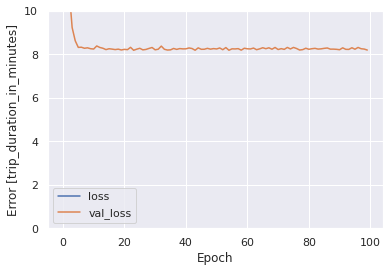

In [165]:
plot_loss(history)

# **Hyperparameter Tuning**